In [1]:
library(tidyverse)
library(assertthat)
library(xtable)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘assertthat’

The following object is masked from ‘package:tibble’:

    has_name



In [2]:
plot_theme <- theme_classic() + 
    theme(strip.background = element_blank(),
          plot.title = element_text(hjust = 0.5),
          plot.subtitle = element_text(hjust = 0.5))

### Evaluation of SubSVDD against benchmark data set 

In [4]:
path <- "../../data/output/evaluation-part1.csv"
data <- read_csv(path, col_types = cols(id=col_character(),
   c_start_quality=col_skip(), c_end_quality=col_skip(), c_maximum=col_skip(), c_ramp_up=col_skip(), c_quality_range=col_skip(), c_total_quality_range=col_skip(), c_average_end_quality=col_skip(),
   c_average_quality_change=col_skip(), c_average_gain=col_skip(), c_average_loss=col_skip(), c_learning_stability=col_skip(), c_ratio_of_outlier_queries=col_skip(), auc_start_quality=col_skip(), 
   auc_end_quality=col_skip(), auc_maximum=col_skip(), auc_ramp_up=col_skip(), auc_quality_range=col_skip(), auc_total_quality_range=col_skip(), auc_average_end_quality=col_skip(), 
   auc_average_quality_change=col_skip(), auc_average_gain=col_skip(), auc_average_loss=col_skip(), auc_learning_stability=col_skip(), auc_ratio_of_outlier_queries=col_skip(), 
   pauc_start_quality=col_skip(), pauc_end_quality=col_skip(), pauc_maximum=col_skip(), pauc_ramp_up=col_skip(), pauc_quality_range=col_skip(), pauc_total_quality_range=col_skip(),
   pauc_average_end_quality=col_skip(), pauc_average_quality_change=col_skip(), pauc_average_gain=col_skip(), pauc_average_loss=col_skip(), pauc_learning_stability=col_skip(), 
   pauc_ratio_of_outlier_queries=col_skip()))

In [5]:
data <- data %>% 
    filter(scenario != "01-subsvdd-smallsubspaces") %>% 
    mutate(data_set = recode_factor(data_set, "Annthyroid" = "Thyroid", 
                                        "Cardiotocography" = "Cardio",
                                       "HeartDisease" = "Heart",
                                       "PageBlocks" = "Page",
                                       "SpamBase" = "Spam"))

In [6]:
data %>%
    group_by(exit_code, data_set) %>%
    count()

exit_code,data_set,n
<chr>,<fct>,<int>
success,Thyroid,180
success,Cardio,180
success,Heart,180
success,Page,180
success,Spam,180
success,Pima,180
success,Stamps,180


In [7]:
data %>% 
    group_by(data_set) %>% 
    summarize(D = max(num_dimensions), N = max(num_points)) %>%
    rename(Data = data_set)

Data,D,N
<fct>,<dbl>,<dbl>
Thyroid,21,1000
Cardio,21,1000
Heart,13,157
Page,10,1000
Spam,57,1000
Pima,8,526
Stamps,9,325


#### Extract experimental run for indepth analysis

In [8]:
data %>% 
    filter(max_size_subspaces == 2, num_subspaces == 10) %>%
    group_by(data_set) %>%
    filter(m_end_quality == max(m_end_quality)) %>%
    select(data_set, m_end_quality, id)

data_set,m_end_quality,id
<fct>,<dbl>,<chr>
Thyroid,0.2439428,2290335932150762610
Cardio,0.4380858,2463357408919718949
Heart,0.9227494,8836302036497489103
Page,0.6685937,9478936085490997477
Pima,0.5616798,7058302765592472691
Spam,0.1552089,8489543019566125086
Spam,0.1552089,8121940164975490016
Stamps,0.3615735,14454761300524196337


### Benchmark Comparison

In [9]:
plotVar <- data %>%
    mutate(file_version = str_extract(file_name, "v\\w{2}"))  %>%
    filter(init_strategy_C == "FixedCStrategy(0.45)" | (init_strategy_C=="BoundedTaxErrorEstimate") & model != "SubSVDD") %>%
    filter(exit_code == "success",
           num_al_iterations==50) %>%
    # !!! Do not filter for min_size_subspaces, as this variable holds the acutal sizes, and not the config limits  !!!
    select(data_set, file_version, num_subspaces, max_size_subspaces, model, qs, qs_combination_fct, weight_update_strategy, m_average_end_quality, m_quality_range, m_end_quality, m_ramp_up, m_ratio_of_outlier_queries, initial_pool_resample_version)

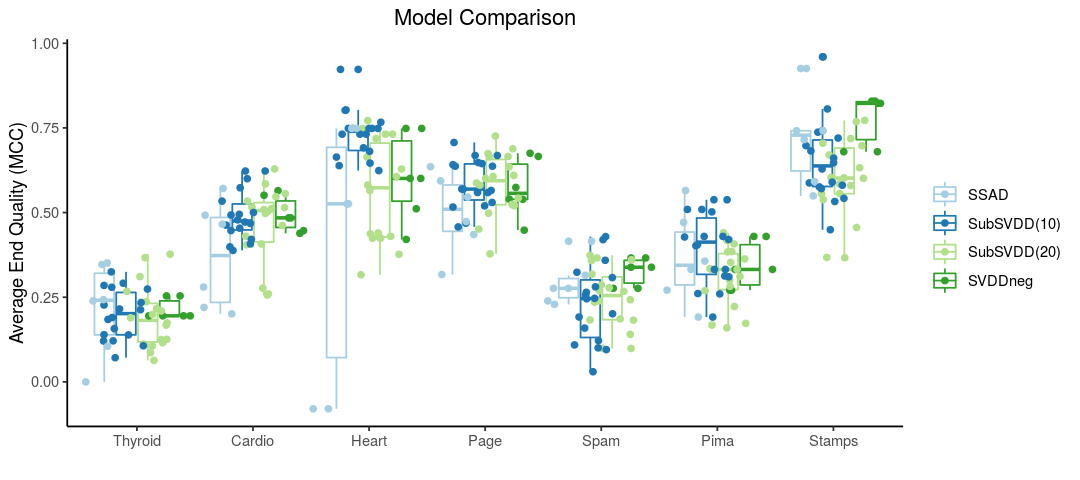

In [10]:
options(repr.plot.width=9, repr.plot.height=4)

pv <- plotVar %>% 
mutate(model = case_when(model == "SubSVDD" ~ paste0(model, "(", num_subspaces, ")"), 
                         model == "SSAD_0.1" ~ "SSAD",
                         TRUE ~ model)) %>%
filter(
       qs != "RandomOutlierPQs", # change this for results with RandomOutlierPQs
       is.na(max_size_subspaces) | max_size_subspaces > 4,
       is.na(qs_combination_fct) | qs_combination_fct == "sum",
       is.na(weight_update_strategy) | weight_update_strategy == "out_0.01-in_10.0")

pv %>%ggplot(aes(y=m_average_end_quality, x=data_set, color = model)) +
    geom_boxplot() +
    geom_point(position = position_jitterdodge()) +
    labs(title="Model Comparison", y="Average End Quality (MCC)", x = "") +
    scale_colour_brewer(palette="Paired") +
    plot_theme +
        theme(legend.title = element_blank())

Nummber of experiments per data set and classifier

In [11]:
pv %>% 
    group_by(data_set, model) %>% 
    summarize(n_exp = n()) %>%
    spread(data_set, n_exp)

model,Thyroid,Cardio,Heart,Page,Spam,Pima,Stamps
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
SSAD,6,6,6,6,6,6,6
SubSVDD(10),18,18,18,18,18,18,18
SubSVDD(20),18,18,18,18,18,18,18
SVDDneg,6,6,6,6,6,6,6


In [12]:
quality_table <- pv %>% 
    group_by(data_set, model) %>%
    summarize(median_average_end_quality = median(m_average_end_quality)) %>%
    rename(" " = data_set) %>%
    spread(model, median_average_end_quality)
quality_table

,SSAD,SubSVDD(10),SubSVDD(20),SVDDneg
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Thyroid,0.2410444,0.2016229,0.1816870,0.1951311
Cardio,0.3730004,0.4752980,0.5061430,0.4843582
Heart,0.5258305,0.7400155,0.5730952,0.6008124
Page,0.5097122,0.5693582,0.5941007,0.5569841
Spam,0.2762340,0.2460899,0.2548855,0.3386564
Pima,0.3444260,0.4128167,0.3321300,0.3321300
Stamps,0.7285907,0.6378826,0.6018970,0.8225281


In [13]:
print(xtable(quality_table,
            caption = "Comparison of Median AEQ after 50 iterations; 5-dim to 8-dim subspaces.",
            latex.environments = "center",
            label="tab:aeq-large-subspaces",
            align = "llcccc"), 
      booktabs = TRUE,
      hline.after = c(0, 7),
      include.rownames = FALSE,
      floating = FALSE,
      file="../tables/quality_table.tex"
     )

In [14]:
roq_table <- pv %>% 
    group_by(data_set, model) %>%
    summarize(median_ratio_of_outlier_queries = median(m_ratio_of_outlier_queries)) %>%
#     rename(" " = data_set) %>%
    spread(model, median_ratio_of_outlier_queries) %>%
    ungroup() %>%
    select(-data_set)
roq_table

SSAD,SubSVDD(10),SubSVDD(20),SVDDneg
<dbl>,<dbl>,<dbl>,<dbl>
0.08,0.09,0.12,0.04
0.19,0.30,0.35,0.32
0.08,0.08,0.07,0.08
0.31,0.48,0.41,0.43
0.08,0.13,0.13,0.12
0.08,0.10,0.08,0.06
0.19,0.18,0.20,0.22


In [15]:
print(xtable(roq_table,
            caption = "Ration of outlier queries after 50 iterations; 5-dim to 8-dim subspaces.",
            latex.environments = "center",
            label="tab:roq-large-subspaces",
            align = "llccc"), 
      booktabs = TRUE,
      include.rownames = FALSE,
      hline.after = c(0, 7),
      floating = FALSE,
      file="../tables/roq_table.tex"
     )

##### Extract experimental run

In [16]:
library(RColorBrewer)
custom_pal <- brewer.pal(5, "Set1")[c(2,3,4)]

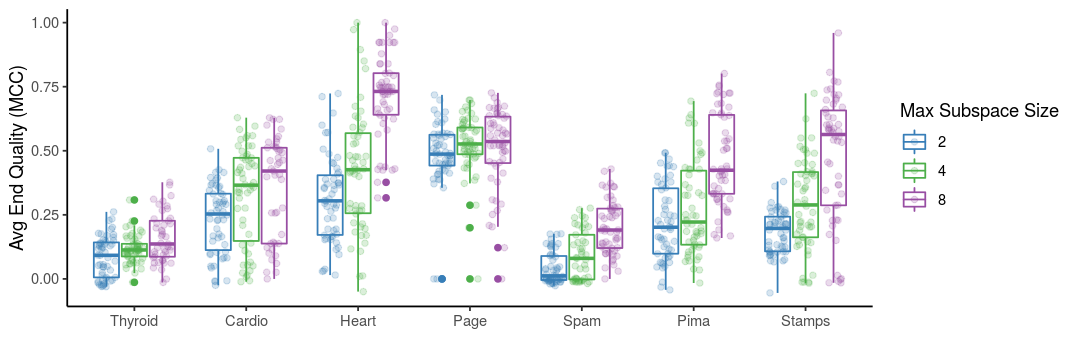

In [17]:
options(repr.plot.width=9, repr.plot.height=3)

plotVar %>% filter(model=="SubSVDD") %>%
    # subspace size is random, so there are a few instances where the maximum size per set is smaller than the limit
    filter(max_size_subspaces != 3, max_size_subspaces !=7) %>% 
    ggplot(aes(x=data_set, y=m_average_end_quality, color=factor(max_size_subspaces))) +
    labs(y="Avg End Quality (MCC)", x = "", color = "Max Subspace Size") +
    geom_boxplot() +
    geom_point(position = position_jitterdodge(), alpha=0.2) +
    scale_colour_manual(values=custom_pal) +
    plot_theme + 
    theme(legend.position = "right")

In [18]:
ggsave("../plots/subsvdd_subspace_size_comparison.pdf", 
       width = 8,
       height = 2,
       plot = last_plot(), device = "pdf")

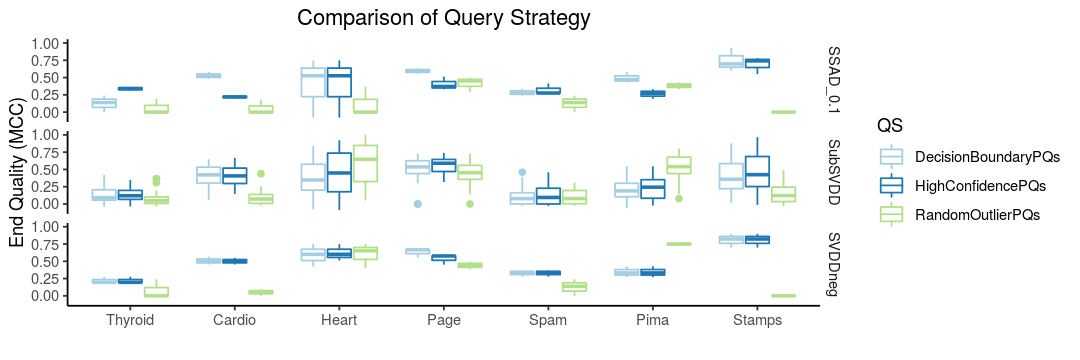

In [19]:
options(repr.plot.width=9, repr.plot.height=3)

plotVar %>% 
#     filter(model=="SubSVDD") %>%
    ggplot(aes(x=data_set, y=m_end_quality, color=factor(qs))) +
    labs(title="Comparison of Query Strategy", y="End Quality (MCC)", x = "", color = "QS") +
    geom_boxplot() +
    scale_colour_brewer(palette="Paired") +
    facet_grid(row=vars(model))+
    plot_theme

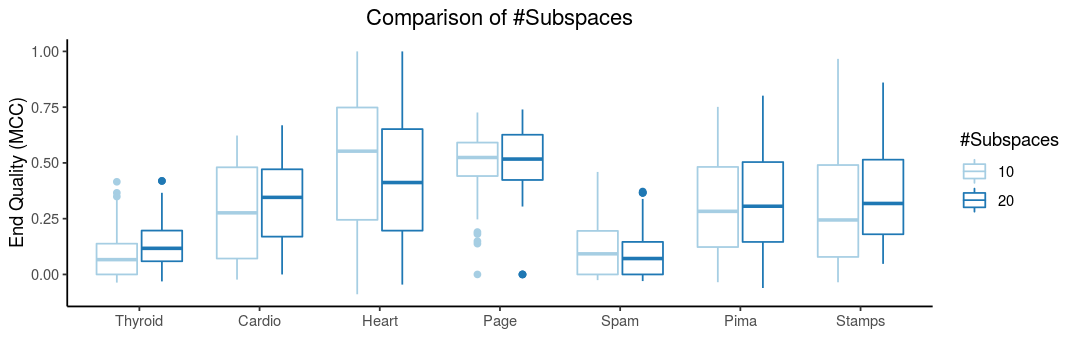

In [20]:
plotVar %>% filter(model=="SubSVDD") %>%
    ggplot(aes(x=data_set, y=m_end_quality, color=factor(num_subspaces))) +
#     geom_point(position = position_jitterdodge()) +
    labs(y="End Quality (MCC)", x = "", color = "#Subspaces") +
    ggtitle("Comparison of #Subspaces") +
    geom_boxplot() +
    scale_colour_brewer(palette="Paired") +
    plot_theme